<a href="https://colab.research.google.com/github/kristinkx/KristinKX/blob/main/Boston_Crimes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [123]:
!pip install opendatasets
!pip install pandas
!pip install wordcloud
!pip install pandasql

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [124]:
import pandasql as ps

import math 

import matplotlib
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

from pandas.plotting import scatter_matrix

%matplotlib inline

import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import random

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_curve, auc, precision_recall_curve
import statsmodels.formula.api as smf
import statsmodels.api as sm
import joblib

import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import OrdinalEncoder

from sklearn import metrics
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

from scipy.cluster.vq import kmeans, vq, whiten
from scipy.spatial.distance import cdist
import numpy as np
from datetime import datetime

import folium
from folium.plugins import HeatMap
from folium import plugins

import wordcloud
from collections import Counter
import nltk
nltk.download('vader_lexicon')
nltk.download('punkt')
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [125]:
import opendatasets as od
import pandas as pd
  
od.download(
    "https://www.kaggle.com/datasets/AnalyzeBoston/crimes-in-boston")

Skipping, found downloaded files in "./crimes-in-boston" (use force=True to force download)


# **Part 1: ETL**

In [126]:
# read the crime file

crime = pd.read_csv('/content/crimes-in-boston/crime.csv', encoding='windows-1252')
crime.head()

INCIDENT_NUMBER  OFFENSE_CODE    OFFENSE_CODE_GROUP   OFFENSE_DESCRIPTION  \
0      I182070945           619               Larceny    LARCENY ALL OTHERS   
1      I182070943          1402             Vandalism             VANDALISM   
2      I182070941          3410                 Towed   TOWED MOTOR VEHICLE   
3      I182070940          3114  Investigate Property  INVESTIGATE PROPERTY   
4      I182070938          3114  Investigate Property  INVESTIGATE PROPERTY   

  DISTRICT REPORTING_AREA SHOOTING     OCCURRED_ON_DATE  YEAR  MONTH  \
0      D14            808      NaN  2018-09-02 13:00:00  2018      9   
1      C11            347      NaN  2018-08-21 00:00:00  2018      8   
2       D4            151      NaN  2018-09-03 19:27:00  2018      9   
3       D4            272      NaN  2018-09-03 21:16:00  2018      9   
4       B3            421      NaN  2018-09-03 21:05:00  2018      9   

  DAY_OF_WEEK  HOUR    UCR_PART       STREET        Lat       Long  \
0      Sunday    13    Part One   LINCOLN ST  42.357791 -71.139371   
1     Tuesday     0    Part Two     HECLA ST  42.306821 -71.060300   
2      Monday    19  Part Three  CAZENOVE ST  42.346589 -71.072429   
3      Monday    21  Part Three   NEWCOMB ST  42.334182 -71.078664   
4      Monday    21  Part Three     DELHI ST  42.275365 -71.090361   

                      Location  
0  (42.35779134, -71.13937053)  
1  (42.30682138, -71.06030035)  
2  (42.34658879, -71.07242943)  
3  (42.33418175, -71.07866441)  
4  (42.27536542, -71.09036101)

In [127]:
# read the offense_code file

codes = pd.read_csv('/content/crimes-in-boston/offense_codes.csv', encoding='windows-1252')
codes.head()

CODE                                     NAME
0   612         LARCENY PURSE SNATCH - NO FORCE 
1   613                      LARCENY SHOPLIFTING
2   615  LARCENY THEFT OF MV PARTS & ACCESSORIES
3  1731                                   INCEST
4  3111                LICENSE PREMISE VIOLATION

In [128]:
crime.shape

(319073, 17)

In [129]:
# find the nulls

crime.isnull().sum()

INCIDENT_NUMBER             0
OFFENSE_CODE                0
OFFENSE_CODE_GROUP          0
OFFENSE_DESCRIPTION         0
DISTRICT                 1765
REPORTING_AREA              0
SHOOTING               318054
OCCURRED_ON_DATE            0
YEAR                        0
MONTH                       0
DAY_OF_WEEK                 0
HOUR                        0
UCR_PART                   90
STREET                  10871
Lat                     19999
Long                    19999
Location                    0
dtype: int64

In [130]:
# drop the 'shooting' column (too many nulls)
# then drop all other na rows

bos = crime.copy()
bos = crime.drop('SHOOTING', axis = 1)
bos.dropna(how = 'any', axis = 0, inplace = True)
bos.shape

(296573, 16)

In [131]:
bos.describe()

OFFENSE_CODE           YEAR          MONTH           HOUR  \
count  296573.000000  296573.000000  296573.000000  296573.000000   
mean     2293.856737    2016.550954       6.611856      13.124576   
std      1182.909512       1.001118       3.279314       6.278383   
min       111.000000    2015.000000       1.000000       0.000000   
25%       802.000000    2016.000000       4.000000       9.000000   
50%      2907.000000    2017.000000       7.000000      14.000000   
75%      3201.000000    2017.000000       9.000000      18.000000   
max      3831.000000    2018.000000      12.000000      23.000000   

                 Lat           Long  
count  296573.000000  296573.000000  
mean       42.300079     -71.046943  
std         0.981040       1.586477  
min        -1.000000     -71.178674  
25%        42.297521     -71.097223  
50%        42.325574     -71.077562  
75%        42.348624     -71.062529  
max        42.395042      -1.000000

In [132]:
# print data type

print(bos.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 296573 entries, 0 to 319072
Data columns (total 16 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   INCIDENT_NUMBER      296573 non-null  object 
 1   OFFENSE_CODE         296573 non-null  int64  
 2   OFFENSE_CODE_GROUP   296573 non-null  object 
 3   OFFENSE_DESCRIPTION  296573 non-null  object 
 4   DISTRICT             296573 non-null  object 
 5   REPORTING_AREA       296573 non-null  object 
 6   OCCURRED_ON_DATE     296573 non-null  object 
 7   YEAR                 296573 non-null  int64  
 8   MONTH                296573 non-null  int64  
 9   DAY_OF_WEEK          296573 non-null  object 
 10  HOUR                 296573 non-null  int64  
 11  UCR_PART             296573 non-null  object 
 12  STREET               296573 non-null  object 
 13  Lat                  296573 non-null  float64
 14  Long                 296573 non-null  float64
 15  Location         

In [133]:
# change the day of week to str

bos['DAY_OF_WEEK']= bos['DAY_OF_WEEK'].astype(str)

In [134]:
# extract month and day from 'OCCURRED_ON_DATE' column

bos['MONTH'] = pd.DatetimeIndex(bos['OCCURRED_ON_DATE']).month
bos['DAY'] = pd.DatetimeIndex(bos['OCCURRED_ON_DATE']).day

In [135]:
codes.shape

(576, 2)

In [136]:
codes.isnull().sum()

CODE    0
NAME    0
dtype: int64

In [137]:
codes.head()

CODE                                     NAME
0   612         LARCENY PURSE SNATCH - NO FORCE 
1   613                      LARCENY SHOPLIFTING
2   615  LARCENY THEFT OF MV PARTS & ACCESSORIES
3  1731                                   INCEST
4  3111                LICENSE PREMISE VIOLATION

In [138]:
# SQL to link the crime code to description

bos_crime_query = '''

SELECT *
FROM bos b
JOIN codes c 
ON b.OFFENSE_CODE = c.CODE

ORDER BY YEAR DESC
'''
boston = ps.sqldf(bos_crime_query, globals())
boston.head()

INCIDENT_NUMBER  OFFENSE_CODE OFFENSE_CODE_GROUP  OFFENSE_DESCRIPTION  \
0      I182070945           619            Larceny   LARCENY ALL OTHERS   
1      I182070945           619            Larceny   LARCENY ALL OTHERS   
2      I182070943          1402          Vandalism            VANDALISM   
3      I182070943          1402          Vandalism            VANDALISM   
4      I182070941          3410              Towed  TOWED MOTOR VEHICLE   

  DISTRICT REPORTING_AREA     OCCURRED_ON_DATE  YEAR  MONTH DAY_OF_WEEK  HOUR  \
0      D14            808  2018-09-02 13:00:00  2018      9      Sunday    13   
1      D14            808  2018-09-02 13:00:00  2018      9      Sunday    13   
2      C11            347  2018-08-21 00:00:00  2018      8     Tuesday     0   
3      C11            347  2018-08-21 00:00:00  2018      8     Tuesday     0   
4       D4            151  2018-09-03 19:27:00  2018      9      Monday    19   

     UCR_PART       STREET        Lat       Long                     Location  \
0    Part One   LINCOLN ST  42.357791 -71.139371  (42.35779134, -71.13937053)   
1    Part One   LINCOLN ST  42.357791 -71.139371  (42.35779134, -71.13937053)   
2    Part Two     HECLA ST  42.306821 -71.060300  (42.30682138, -71.06030035)   
3    Part Two     HECLA ST  42.306821 -71.060300  (42.30682138, -71.06030035)   
4  Part Three  CAZENOVE ST  42.346589 -71.072429  (42.34658879, -71.07242943)   

   DAY  CODE                       NAME  
0    2   619         LARCENY ALL OTHERS  
1    2   619  LARCENY OTHER $200 & OVER  
2   21  1402                  VANDALISM  
3   21  1402                  VANDALISM  
4    3  3410        TOWED MOTOR VEHICLE

In [155]:
boston = boston.rename(columns={'NAME': 'OFFENSE_NAME'})
boston.columns

Index(['INCIDENT_NUMBER', 'OFFENSE_CODE', 'OFFENSE_CODE_GROUP',
       'OFFENSE_DESCRIPTION', 'DISTRICT', 'REPORTING_AREA', 'OCCURRED_ON_DATE',
       'YEAR', 'MONTH', 'DAY_OF_WEEK', 'HOUR', 'UCR_PART', 'STREET', 'Lat',
       'Long', 'Location', 'DAY', 'CODE', 'OFFENSE_NAME'],
      dtype='object')

In [156]:
boston['OFFENSE_CODE_GROUP'].unique().tolist()

['Larceny',
 'Vandalism',
 'Towed',
 'Investigate_Property',
 'Motor_Vehicle_Accident_Response',
 'Auto_Theft',
 'Verbal_Disputes',
 'Robbery',
 'Fire_Related_Reports',
 'Other',
 'Property_Lost',
 'Assembly_or_Gathering_Violations',
 'Larceny_From_Motor_Vehicle',
 'Medical_Assistance',
 'Residential_Burglary',
 'Simple_Assault',
 'Restraining_Order_Violations',
 'Violations',
 'Harassment',
 'Ballistics',
 'Property_Found',
 'Police_Service_Incidents',
 'Disorderly_Conduct',
 'Property_Related_Damage',
 'Missing_Person_Reported',
 'Investigate_Person',
 'Fraud',
 'Drug_Violation',
 'Aggravated_Assault',
 'License_Plate_Related_Incidents',
 'Firearm_Violations',
 'Other_Burglary',
 'Arson',
 'Warrant_Arrests',
 'Bomb_Hoax',
 'Counterfeiting',
 'Liquor_Violation',
 'Firearm_Discovery',
 'Landlord/Tenant_Disputes',
 'Missing_Person_Located',
 'Auto_Theft_Recovery',
 'Service',
 'Operating_Under_the_Influence',
 'Confidence_Games',
 'Search_Warrants',
 'License_Violation',
 'Commercial_Bu

In [226]:
# replace the spce with underscore

boston['OFFENSE_CODE_GROUP'].replace('\s+', '_',regex=True,inplace=True)
# boston['OFFENSE_CODE_GROUP'].unique().tolist()
# print(len(boston['OFFENSE_CODE_GROUP'].unique().tolist()))

In [229]:
# correlation 
bos_corr = boston.corr()
bos_corr

OFFENSE_CODE      YEAR     MONTH      HOUR       Lat      Long  \
OFFENSE_CODE      1.000000  0.045272 -0.015695 -0.019731  0.000109 -0.003036   
YEAR              0.045272  1.000000 -0.384085  0.002055  0.002000 -0.002472   
MONTH            -0.015695 -0.384085  1.000000  0.002873  0.002475 -0.002255   
HOUR             -0.019731  0.002055  0.002873  1.000000  0.001653 -0.002688   
Lat               0.000109  0.002000  0.002475  0.001653  1.000000 -0.999087   
Long             -0.003036 -0.002472 -0.002255 -0.002688 -0.999087  1.000000   
DAY              -0.009123 -0.017904 -0.014143  0.010476  0.000264 -0.000275   
CODE              1.000000  0.045272 -0.015695 -0.019731  0.000109 -0.003036   

                   DAY      CODE  
OFFENSE_CODE -0.009123  1.000000  
YEAR         -0.017904  0.045272  
MONTH        -0.014143 -0.015695  
HOUR          0.010476 -0.019731  
Lat           0.000264  0.000109  
Long         -0.000275 -0.003036  
DAY           1.000000 -0.009123  
CODE         -0.009123  1.000000

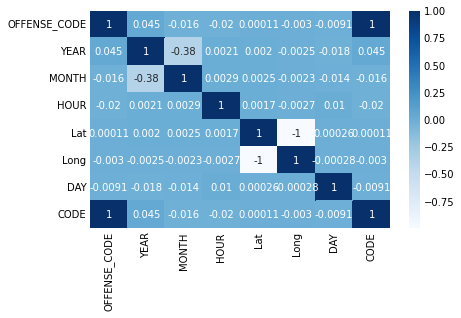

In [231]:
# correlation heatmap - no significant correlations between the variables

sns.heatmap(bos_corr, cmap ="Blues", annot =True);

# **Part 2: Visualization**

In [162]:
# boston crime heatmap (use 200000 crimes in the boston dataset)

lon = boston['Long']
lat = boston['Lat']

average_Lon = sum(lon)/len(lon)
average_Lat = sum(lat)/len(lat)

boston_location = boston[['OFFENSE_CODE_GROUP','Long', 'Lat']]
bost = boston_location.groupby(['OFFENSE_CODE_GROUP']).mean().reset_index()

# this part calls the folium.Map funcion, the bigger the zoom_start, the closer in 
crime_map = folium.Map(location=[average_Lat, average_Lon],
                      zoom_start = 11)

# add the crime data to the heat map
crime_heatmap = boston[-200000:]
crime_heatmap = crime_heatmap[['Lat','Long']]
data_heatmap = [[row['Lat'],row['Long']] for index, row in crime_heatmap.iterrows()]
HeatMap(crime_heatmap, radius = 12).add_to(crime_map)

folium.TileLayer('Stamen Terrain').add_to(crime_map)

crime_map

In [224]:
# boston.columns

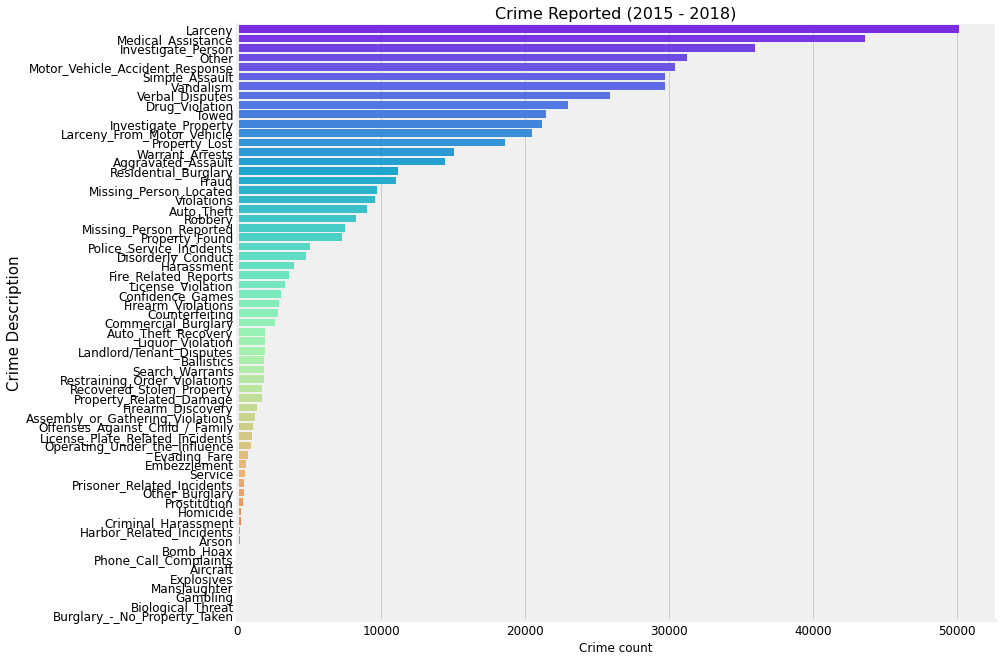

In [145]:
# graph for offense description 

sns.catplot(y='OFFENSE_CODE_GROUP',
           kind ='count',
           height = 9,
           aspect = 1.5, 
           palette=("rainbow"),
           order=boston.OFFENSE_CODE_GROUP.value_counts().index,
           data=boston)

plt.xticks(size=12)
plt.yticks(size=12)
plt.xlabel("Crime count", fontsize = 12)
plt.ylabel("Crime Description", fontsize = 15)
plt.title("Crime Reported (2015 - 2018)", fontsize = 16);

In [146]:
# remove some of the group code that are more neutral words (aircraft, servic, other etc)

boston_cloud_query = '''
SELECT * 
FROM boston

WHERE NOT "OFFENSE_CODE_GROUP" IN ("Aircraft", "Service", "Confidence_Games",
                                        "Towed", "Medical_Assistance", "Other")
'''

boston_cloud = ps.sqldf(boston_cloud_query, globals())

In [147]:
# wordcloud for offense creported in the dataset
# from nltk.corpus import stopwords

import nltk
nltk.download('stopwords')

stop_words = set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


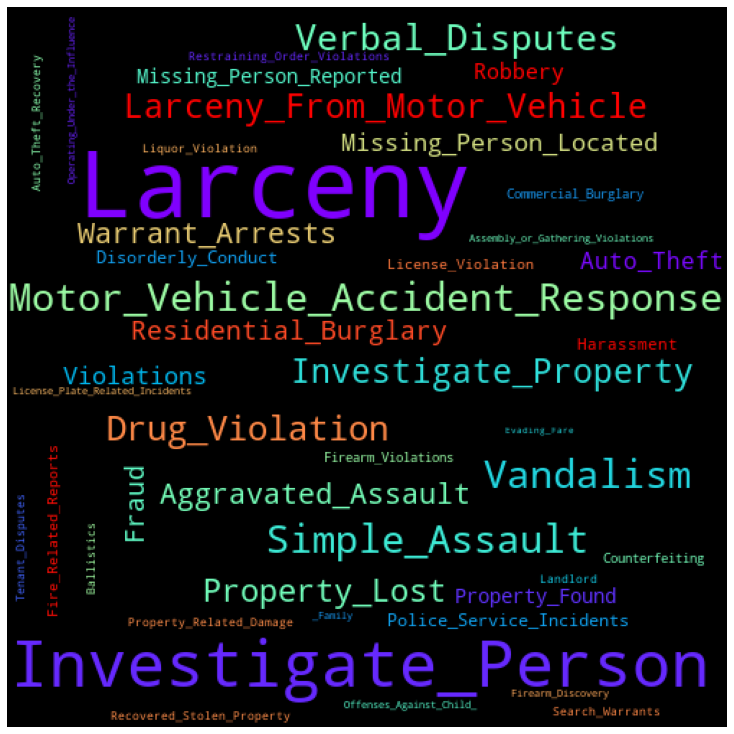

In [148]:
# wordcloud of the crime description

from wordcloud import WordCloud

most_common = " ".join(i for i in boston_cloud['OFFENSE_CODE_GROUP'])

wordcloud = WordCloud(width = 500, height = 500, 
                      background_color = 'black',
                      stopwords = stop_words,
                      mask = None,  contour_color = 'blue',  
                      min_font_size = 6, collocations=False,
                      max_font_size = None, mode = 'RGB',
                      colormap = 'rainbow').generate(most_common)                                     


# plot word cloud
plt.figure(figsize = (15, 10), facecolor = None)
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad = 0)

plt.show()

In [223]:
# boston['OFFENSE_CODE_GROUP'].unique().tolist()

In [217]:
# crime_2017 map by offense code group

crime_2017_query = '''

SELECT "Long", "Lat", "OFFENSE_CODE_GROUP", "CODE", 
"YEAR", "MONTH", "DAY", "HOUR", "DISTRICT"
FROM boston
WHERE "OFFENSE_CODE_GROUP" IN ("Homicide","Firearm_Violations", 
                               "Criminal_Harassment", "Aggravated_Assault",
                               "Arson")
AND "YEAR" = 2017

LIMIT 500

'''
crime_2017 = ps.sqldf(crime_2017_query, globals())
# crime_2017.head()
# crime_2017.shape

In [219]:
# define colors of the offense_code_group 

def select_marker_color(row):
    if row['OFFENSE_CODE_GROUP'] == 'Homicide':
        return 'red'
    elif row['OFFENSE_CODE_GROUP'] == 'Firearm_Violations':
        return 'green'
    elif row['OFFENSE_CODE_GROUP'] == 'Criminal_Harassment':
        return 'black'
    elif row['OFFENSE_CODE_GROUP'] == 'Arson':
        return 'orange'
    else: 
        return 'blue'

crime_2017['colors'] = crime_2017.apply(select_marker_color, axis = 1 )
crime_2017.head()

Long        Lat  OFFENSE_CODE_GROUP  CODE  YEAR  MONTH  DAY  HOUR  \
0 -71.096444  42.347174  Aggravated_Assault   413  2017     12   21    23   
1 -71.096444  42.347174  Aggravated_Assault   413  2017     12   21    23   
2 -71.143743  42.243807  Aggravated_Assault   423  2017     10    9     2   
3 -71.143743  42.243807  Aggravated_Assault   423  2017     10    9     2   
4 -71.138591  42.278298  Aggravated_Assault   423  2017      9    3    22   

  DISTRICT colors  
0       D4   blue  
1       D4   blue  
2      E18   blue  
3      E18   blue  
4       E5   blue

In [220]:
crime_2017['OFFENSE_CODE_GROUP'].value_counts()

Aggravated_Assault     403
Firearm_Violations      69
Homicide                12
Arson                    8
Criminal_Harassment      8
Name: OFFENSE_CODE_GROUP, dtype: int64

In [174]:
# crime_2017.head()

In [221]:
# major crimes in 2017 in Boston map
# interactive: the 'i' on the markers shows the police district where the crime committed

crime_2017_map = folium.Map(
    location = [42.347174,-71.096444], zoom_start = 2
)

for _, scene in crime_2017.iterrows():
    folium.Marker(
    location = [scene['Lat'], scene['Long']],
        popup = scene['DISTRICT'], 
        icon = folium.Icon(color = scene['colors'])
    ).add_to(crime_2017_map)
    
crime_2017_map

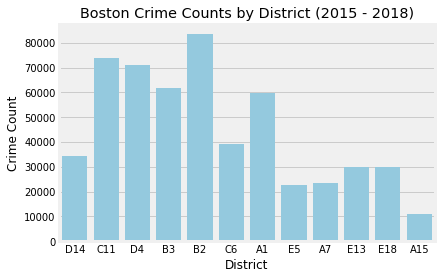

In [150]:
# plot a graph of crimes by district 

boston_dis = boston.DISTRICT.tolist()

dist_bins = np.array(boston_dis)
sns.countplot(boston['DISTRICT'], color='skyblue')
plt.title("Boston Crime Counts by District (2015 - 2018)")
plt.xlabel("District")
plt.ylabel("Crime Count")
plt.show()

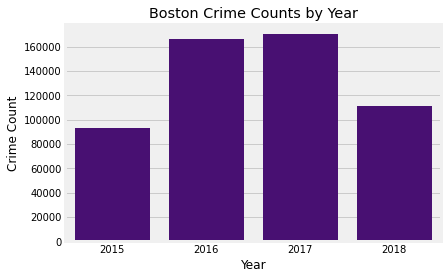

In [151]:
# plot graph of crimes over the years

year_list = boston.YEAR.tolist()

dist_bins = np.array(year_list)
sns.countplot(boston['YEAR'], color='indigo')
plt.title("Boston Crime Counts by Year")
plt.xlabel("Year")
plt.ylabel("Crime Count")
plt.show()

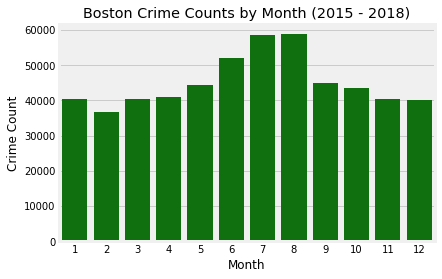

In [152]:
# plot graph of the crime by month

boston_month = boston.MONTH.tolist()

dist_bins = np.array(boston_month)
sns.countplot(boston['MONTH'], color='green')
plt.title("Boston Crime Counts by Month (2015 - 2018)")
plt.xlabel("Month")
plt.ylabel("Crime Count")
plt.show()

In [153]:
# boston_day = boston.DAY.tolist()

# dist_bins = np.array(boston_day)
# sns.countplot(boston['DAY'], color='gold')
# plt.title("Boston Crime Counts by Day of the Month (2015 - 2018)")
# plt.xlabel("Day of the Month")
# plt.ylabel("Crime Count")
# plt.show()

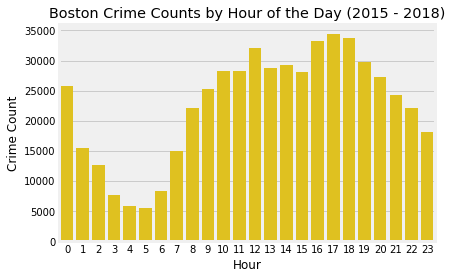

In [222]:
boston_hour = boston.HOUR.tolist()

dist_bins = np.array(boston_hour)
sns.countplot(boston['HOUR'], color='gold')
plt.title("Boston Crime Counts by Hour of the Day (2015 - 2018)")
plt.xlabel("Hour")
plt.ylabel("Crime Count")
plt.show()